In [109]:
import pandas as pd 
import numpy as np
import string, re
import nltk
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

from time import time
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('Data/tweets.txt', sep = ';~;', engine='python')
PositiveTweets = pd.read_csv('Data/tweetsPositive.txt', sep = ';~;', engine='python')
NegativeTweets = pd.read_csv('Data/tweetsNegative.txt', sep = ';~;', engine='python')

emoji_list = pd.read_csv('Data/emoji_table.txt', encoding='utf-8', index_col=0).index.values
SentimentEmoji = pd.read_csv('Data/Emoji_classification.csv', encoding='utf-8').dropna()
SentimentHashtags = pd.read_csv('Data/hashtags.csv', encoding='utf-8').dropna()

## The test set for hillary
hillaryTest = pd.read_csv('Hillary.csv')
TrumpTest = pd.read_csv('Trump.csv')

In [3]:
# List of positive and negative tweets
sad = [':‑(', ':(', ':‑c', ':c', ':‑<', ':<', ':‑[' ,':[', ':-||', '>:[', ':{', ':@', '>:(']
Positive = [':‑)',':)', ':-]', ':]',':-3', ':3', ':->', ':>' ,'8-)', '8)',':-}', ':}', ':o)', ':c)', ':^)' ,'=]', '=)'
           ,':‑D', ':D', '8‑D', '8D', 'x‑D', 'xD', 'X‑D', 'XD', '=D', '=3', 'B^D']
SentimentHashtags['HashtagSentiment'] = SentimentHashtags['HashtagSentiment'].map({'Positive':1, 'Negative':-1})
SentimentEmoji['Sentiment'] = SentimentEmoji['Sentiment'].map({'Positive':1, 'Negative':-1, 'Neutral':0}).dropna()
SentimentHashtags['Directed'] = SentimentHashtags['Directed'].map({'T':1, 'H':0})
hillaryTest.Sentiment = hillaryTest.Sentiment.map({'Positive':1, 'Negative':-1, 'Neutral':0})
TrumpTest.Sentiment = TrumpTest.Sentiment.map({'Positive':1, 'Negative':-1, 'Neutral':0})

In [4]:
stop_list = nltk.corpus.stopwords.words('english') + ["rt"] # rt - stands for retweet
lemmatizer = nltk.stem.WordNetLemmatizer()

# regex for capturing tweets
reg = '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)'
emoticons = "|".join(map(re.escape, sad + Positive))

emoji_pattern = re.compile(u'('
    u'\ud83c[\udf00-\udfff]|'
    u'\ud83d[\udc00-\ude4f\ude80-\udeff]|'
    u'[\u2600-\u26FF\u2700-\u27BF])+', 
    re.UNICODE)
classifier =[]
def preprocess(tweet):
    # only processing if the the value is a string
    if type(tweet)!=type(2.0):
        tweet = tweet.decode('latin-1').encode("utf-8").decode('utf-8').strip()
        tweet = tweet.lower()
        # Removing hashtags
        tweet = " ".join(tweet.split('#'))
        # Removing URLs
        tweet = re.sub('((www\.[^\s]+)|(https://[^\s]+))','',tweet)
        tweet = re.sub('((pic\.[^\s]+)|(https://[^\s]+))','',tweet)
        tweet = re.sub("(http\S+)|(https\S+)", '', tweet)
        # Adding this pattern to the last cause it will remove everything after the start of a URL
        tweet = re.sub(u'[a-zA-Z0-9./]+\.[a-zA-Z0-9./ ]+.*$','',tweet)
        
        # Removing User mentions
        tweet = re.sub('@[^\s]+','',tweet)
        tweet = tweet.strip('\'"')
        # Removing stop words - This can be moved to count vectorization
        # tweet  = " ".join([word for word in tweet.split(" ") if word not in stop_list])
        # lemmatizing words 
        tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet.split(" ")])
    else:
        tweet=''
    return tweet

def extractEmoticons(tweet):
    # emoji = emoji_pattern.findall(tweet)
    emoji = []
    for emo in emoji_list:
        if emo in tweet:
            emoji.append(emo)
    
    # these are :) :-) and other stuff
    emoticons = re.findall(reg, tweet)
    return " , ".join(emoji + emoticons)
def removeEmoticons(tweet):
    return re.sub(reg,'',tweet)

#Processing the tweets
data['processed_text'] = data.text.apply(preprocess)
hillaryTest['processed_text'] = hillaryTest.processed_text.apply(preprocess)
TrumpTest['processed_text'] = TrumpTest.processed_text.apply(preprocess)
PositiveTweets['processed_text'] = PositiveTweets.text.apply(preprocess)
NegativeTweets['processed_text'] = NegativeTweets.text.apply(preprocess)


#getting the emoticons from the cleaned data
data['emoticons'] = data['processed_text'].apply(extractEmoticons)

# Removing emoticons from the text data
data['processed_text'] = data['processed_text'].apply(removeEmoticons)

data = data.append(PositiveTweets).append(NegativeTweets)
print 'Completed'

Completed


In [10]:
HillaryTweets = data[data['processed_text'].str.contains('((hil.?ary)|(clinton))', case = False)]
DonaldTweets = data[data['processed_text'].str.contains('trump', case = False)]

datasets = [HillaryTweets.copy(), DonaldTweets.copy()]
TrainSets = []
for i, dataset in enumerate(datasets):
    hashtags = datasets[i]['hashtags'].copy().str.split(' ').apply(pd.Series, 1).stack()
    hashtags.index = hashtags.index.droplevel(-1)
    datasets[i].drop('hashtags', axis=1, inplace=True)
    hashtags.name = 'hashtags'
    
    datasets[i] = datasets[i].join(hashtags.str.strip())
    
    emoticons = datasets[i]['emoticons'].copy().str.split(' ').apply(pd.Series, 1).stack()
    emoticons.index = emoticons.index.droplevel(-1)
    datasets[i].drop('emoticons', axis=1, inplace=True)
    emoticons.name = 'emoticons'
    datasets[i] = datasets[i].join(emoticons.str.strip())
    
    Directed_hashtags = SentimentHashtags[SentimentHashtags['Directed'] == i].copy() 
    Opp_hashtags = SentimentHashtags[SentimentHashtags['Directed'] != i].copy()
    Opp_hashtags.loc[: ,'HashtagSentiment'] = Opp_hashtags.HashtagSentiment * -1;
    Directed_hashtags = Directed_hashtags.append(Opp_hashtags)
    
    datasets[i] = pd.merge(datasets[i], Directed_hashtags, on = 'hashtags', how='outer')
    datasets[i] = pd.merge(datasets[i], SentimentEmoji, on = 'emoticons', how='outer')
    
    sentiments_num = [-1, 0, 1]
    HashtagsSentiments = []
    EmoticonsSentiments = []
    for senti in sentiments_num:
        temp_hashtag = datasets[i][datasets[i].HashtagSentiment == senti]
        temp_emoticon = datasets[i][datasets[i].Sentiment == senti]
        temp_hashtag = temp_hashtag[['processed_text','HashtagSentiment']].dropna().groupby(['processed_text']).count().reset_index()
        temp_hashtag.columns = ['processed_text','HashtagSentiment_'+str(senti)]
        temp_emoticon = temp_emoticon[['processed_text','Sentiment']].dropna().groupby(['processed_text']).count().reset_index()
        temp_emoticon.columns = ['processed_text','Sentiment_'+str(senti)]
        HashtagsSentiments.append(temp_hashtag)
        EmoticonsSentiments.append(temp_emoticon)
    TrainSets.append(datasets[i])
    datasets[i] = pd.DataFrame(datasets[i]['processed_text'].unique())
    datasets[i].columns = ['processed_text']
    
    for count in HashtagsSentiments:
        datasets[i] = pd.merge(datasets[i], count, on='processed_text', how = 'outer')
    for count in EmoticonsSentiments:
        datasets[i] = pd.merge(datasets[i], count, on='processed_text', how = 'outer')
    #TrainSets.append(datasets[i][['username', 'date', 'processed_text', 'Sentiment']].dropna().groupby(['processed_text', 'Sentiment']).max().reset_index())

/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


In [11]:
datasets[0] = datasets[0].fillna(0)
datasets[1] = datasets[1].fillna(0)
def calculate_sentiment(row):
    neg = row['HashtagSentiment_-1'] + row['Sentiment_-1']
    neu = row.HashtagSentiment_0 + row.Sentiment_0
    pos = row.HashtagSentiment_1 + row.Sentiment_1
    if((neg == neu) and (neu == pos) and (pos == 0.0)):
        return -2
    if(neg > neu and neg > pos):
        return -1
    elif (neu > neg and neu > pos):
        return 0
    elif (pos > neg and pos > neu):
        return 1
    else:
        return 3
datasets[0]['finalSentiment'] = datasets[0].apply(calculate_sentiment, axis = 1)
datasets[1]['finalSentiment'] = datasets[1].apply(calculate_sentiment, axis = 1)

## Things to remember about the test dataset:
1. They do not contain emoticons. We used all the tweets with emoticons for training as they were very less

## Things to try out
1. Once features are completed we can try and use ensembling techniques
2. Run the best model on the remaining dataset to get a popularity score of the candidates - DONE
3. Plot the prediction as a time series plot using the date column

In [141]:
print 'Prediction accuracy for Hillary'
HillaryVectorizer = ''
HillaryModel = ''
data_train = datasets[0][~((datasets[0].finalSentiment == 3) | (datasets[0].finalSentiment == -2))][['processed_text','finalSentiment']].copy().dropna()
vectorizers = [TfidfVectorizer(stop_words=stop_list,ngram_range = (1,3)), TfidfVectorizer(stop_words=stop_list),
               CountVectorizer(stop_words=stop_list,ngram_range = (1,3)), CountVectorizer(stop_words=stop_list),
               HashingVectorizer(stop_words=stop_list,ngram_range = (1,3)), HashingVectorizer(stop_words=stop_list),]
vectorizersName = ['TF-IDF', 'TF-IDF with out ngram', 'Count Vectorizer', 'Count Vectorizer with out ngram',
                  'Hash Vectorizer', 'Hash Vectorizer with out ngram']
for k, vectorizer in enumerate(vectorizers):
    HillaryVectorizer = vectorizer.fit(data_train.processed_text.append(hillaryTest.processed_text))
    X = HillaryVectorizer.transform(data_train.processed_text.append(hillaryTest.processed_text))
    X_train = X[0:data_train.processed_text.shape[0]]
    Y_train = data_train['finalSentiment']
    X_test = X[data_train.processed_text.shape[0]:]
    models = [RandomForestClassifier(), LinearSVC(), GradientBoostingClassifier()]
    modelsName = ['RandomForest','Linear SVC', 'GradientBoost']
    for m, model in enumerate(models):
        model.fit(X_train, Y_train)
        HillaryModel = model
        preds = model.predict(X_test.todense())
        score = 0
        tot = 0
        for i, pred in enumerate(preds):
            if(hillaryTest.Sentiment[i] == hillaryTest.Sentiment[i]):
                tot+=1
                if(hillaryTest.Sentiment[i] == pred):
                    score+=1

        print 'The score for Vectorizer:', vectorizersName[k],', Model:', modelsName[m], score, tot

Prediction accuracy for Hillary
The score for Vectorizer: Count Vectorizer , Model: Linear SVC 46 72


In [139]:
print 'Prediction accuracy for Donald Trump'
DonaldVectorizer = ''
DonaldModel = ''
data_train = datasets[1][~((datasets[1].finalSentiment == 3) | (datasets[1].finalSentiment == -2))][['processed_text','finalSentiment']].copy().dropna()
vectorizers = [TfidfVectorizer(stop_words=stop_list,ngram_range = (1,3)), TfidfVectorizer(stop_words=stop_list),
               CountVectorizer(stop_words=stop_list,ngram_range = (1,3)), CountVectorizer(stop_words=stop_list),
               HashingVectorizer(stop_words=stop_list,ngram_range = (1,3)), HashingVectorizer(stop_words=stop_list)]
vectorizersName = ['TF-IDF', 'TF-IDF with out ngram', 'Count Vectorizer', 'Count Vectorizer with out ngram',
                  'Hash Vectorizer', 'Hash Vectorizer with out ngram']
for k, vectorizer in enumerate(vectorizers):
    DonaldVectorizer = vectorizer.fit(data_train.processed_text.append(TrumpTest.processed_text))
    X = DonaldVectorizer.transform(data_train.processed_text.append(TrumpTest.processed_text))
    X_train = X[0:data_train.processed_text.shape[0]]
    Y_train = data_train['finalSentiment']
    X_test = X[data_train.processed_text.shape[0]:]
    models = [RandomForestClassifier(), LinearSVC(), GradientBoostingClassifier()]
    modelsName = ['RandomForest','Linear SVC', 'GradientBoost']
    for m, model in enumerate(models):
        model.fit(X_train, Y_train)
        DonaldModel = model
        preds = model.predict(X_test.todense())
        score = 0
        tot = 0
        for i, pred in enumerate(preds):
            if(TrumpTest.Sentiment[i] == TrumpTest.Sentiment[i]):
                tot+=1
                if(TrumpTest.Sentiment[i] == pred):
                    score+=1

        print 'The score for Vectorizer:', vectorizersName[k],', Model:', modelsName[m], score, tot


Prediction accuracy for Donald Trump
The score for Vectorizer: TF-IDF , Model: RandomForest 42 66
The score for Vectorizer: TF-IDF , Model: Linear SVC 43 66
The score for Vectorizer: TF-IDF , Model: GradientBoost 38 66
The score for Vectorizer: TF-IDF with out ngram , Model: RandomForest 45 66
The score for Vectorizer: TF-IDF with out ngram , Model: Linear SVC 46 66
The score for Vectorizer: TF-IDF with out ngram , Model: GradientBoost 38 66
The score for Vectorizer: Count Vectorizer , Model: RandomForest 40 66
The score for Vectorizer: Count Vectorizer , Model: Linear SVC 40 66
The score for Vectorizer: Count Vectorizer , Model: GradientBoost 38 66
The score for Vectorizer: Count Vectorizer with out ngram , Model: RandomForest 32 66
The score for Vectorizer: Count Vectorizer with out ngram , Model: Linear SVC 43 66
The score for Vectorizer: Count Vectorizer with out ngram , Model: GradientBoost 38 66
The score for Vectorizer: Hash Vectorizer , Model: RandomForest 40 66
The score for V

In [ ]:
###### import logging
from gensim.models import word2vec

def get_words(tweet):
    return tweet.split(' ')
tweets = pd.Series(data['processed_text'].unique()).apply(get_words)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 140    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)

print "Training model..."
model = word2vec.Word2Vec(tweets, workers=num_workers, size=num_features, min_count = min_word_count, window = context,
                          sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "30features_40minwords_10context"
model.save(model_name)

In [142]:
def is_str(s):
    return isinstance(s, basestring)
print "Analysing Hillary Clinton's popularity"
data_train = datasets[0][(datasets[0].finalSentiment == -2)][['processed_text']].copy().dropna()
data_train['IsString'] = data_train.processed_text.apply(is_str)
data_train_Hillary = data_train[data_train['IsString'] == True]['processed_text'].copy()
X = HillaryVectorizer.transform(data_train_Hillary)
preds_Hillary = HillaryModel.predict(X.todense())

Analysing Hillary Clinton's popularity


In [70]:
print "Analysing Donald Trump's popularity"
data_train = datasets[1][(datasets[1].finalSentiment == -2)][['processed_text']].copy().dropna()
data_train['IsString'] = data_train.processed_text.apply(is_str)
data_train_Donald = data_train[data_train['IsString'] == True]['processed_text'].copy()
X = DonaldVectorizer.transform(data_train_Donald)
preds_Donald = DonaldModel.predict(X.todense())

Analysing Donald Trump's popularity


In [143]:
Date_Info = TrainSets[0][['date', 'processed_text']].drop_duplicates().dropna()
Analysis_Hillary = pd.DataFrame(pd.Series(preds_Hillary))
Analysis_Hillary['processed_text'] = data_train_Hillary #datasets[0][(datasets[0].finalSentiment == -2)][['processed_text']].copy().dropna()
Analysis_Hillary = pd.merge(Analysis_Hillary, Date_Info, on = 'processed_text', how = 'inner')
Analysis_Hillary.columns = ['Predicted Sentiment', 'processed_text', 'date']
Analysis_Hillary['date'] = pd.to_datetime(Analysis_Hillary.date, format = '%Y-%m-%d %H:%M').dt.date
Analysis_Hillary['Predicted Sentiment'] = Analysis_Hillary['Predicted Sentiment'].map({-1:'Negative', 0:'Neutral', 1:'Positive'})
Analysis_Hillary = Analysis_Hillary[['date', 'Predicted Sentiment']]
#Analysis_Hillary.columns = ['date', 'Predicted Sentiment', 'Count']

In [123]:
Date_Info = TrainSets[1][['date', 'processed_text']].drop_duplicates().dropna()
Analysis_Donald = pd.DataFrame(pd.Series(preds_Donald))
Analysis_Donald['processed_text'] = data_train_Donald #datasets[0][(datasets[0].finalSentiment == -2)][['processed_text']].copy().dropna()
Analysis_Donald = pd.merge(Analysis_Donald, Date_Info, on = 'processed_text', how = 'inner')
Analysis_Donald.columns = ['Predicted Sentiment', 'processed_text', 'date']
Analysis_Donald['date'] = pd.to_datetime(Analysis_Donald.date, format = '%Y-%m-%d %H:%M').dt.date
Analysis_Donald['Predicted Sentiment'] = Analysis_Donald['Predicted Sentiment'].map({-1:'Negative', 0:'Neutral', 1:'Positive'})
Analysis_Donald = Analysis_Donald[['date', 'Predicted Sentiment']]

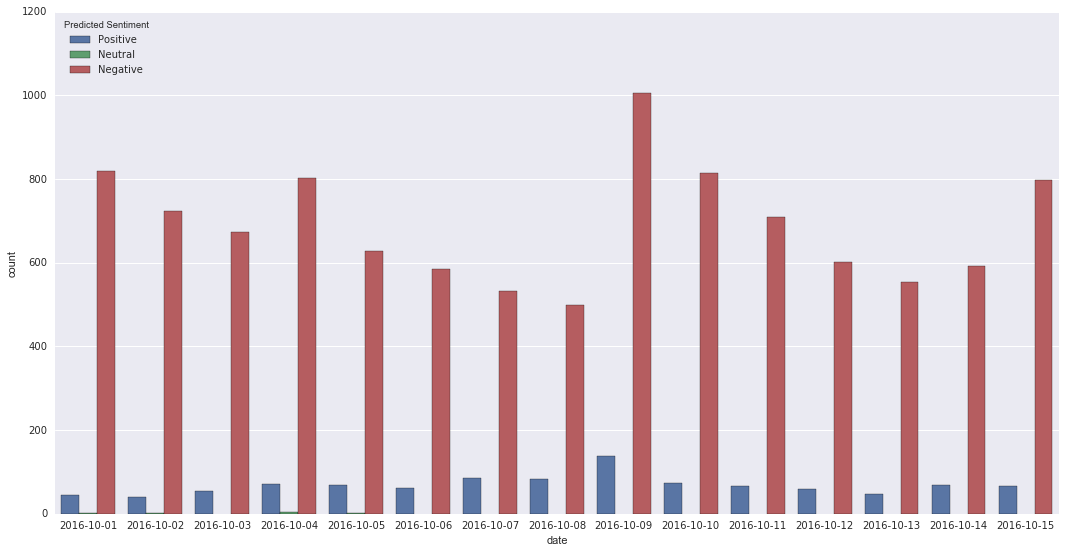

In [144]:
import seaborn as sns
from datetime import datetime

plt.figure(figsize = (18, 9))
sns.countplot(x ="date", hue="Predicted Sentiment",hue_order = ['Positive', 'Neutral', 'Negative'],
              data=Analysis_Hillary[Analysis_Hillary.date >= datetime.strptime('2016-10-01', '%Y-%m-%d').date()].sort_values(by = 'date'))

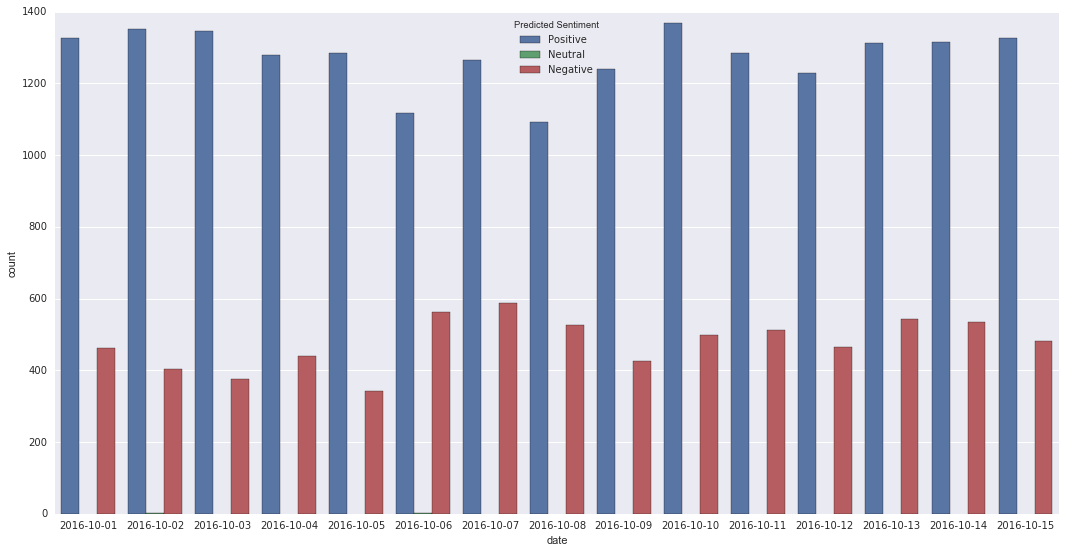

In [145]:
plt.figure(figsize = (18, 9))
sns.countplot(x ="date", hue="Predicted Sentiment",hue_order = ['Positive', 'Neutral', 'Negative'],
              data=Analysis_Donald[Analysis_Donald.date >= datetime.strptime('2016-10-01', '%Y-%m-%d').date()].sort_values(by = 'date'))

In [101]:
Analysis_Donald[Analysis_Donald.date >= pd.]

(11375, 3)

datetime.datetime(2016, 10, 1, 0, 0)

In [51]:
temp = datasets[0][~((datasets[0].finalSentiment == 3) | (datasets[0].finalSentiment == -2))][['processed_text','finalSentiment']].copy().dropna()
temp['IsString'] = temp.processed_text.apply(is_str)